# Adult Income Prediction notebook
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). *The prediction task is to determine whether a person makes over  USD 50K a year.*  
This is a binary classification problem where we have to predict whether a person earns over $50k per year or not. The scoring function to optimize is accuracy. The notebook follows the following steps to analyse the data and build predictive models.
- Data cleaning and preprocessing
- Exploratory data analysis
- Modelling: I have tried out different classification algorithms.
  - Random forest
  - XGBoost
  - Naive Bayes
  - Logistic regression
  - CatBoost  
These models were then optimized by tuning the hyper-parameters through Grid Search, keeping a close check on the cross-validation scores to prevent overfitting. Thereafter I also tried out stacking different models together to improve the accuracy but it didn't improve the accuracy sigificantly.
- Finally I explored oversampling techniques including SMOTE (in progress).

Please feel free to suggest/comment.

<img src="money.jpg" style="width: 700px;"/>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import seaborn as sns
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
sns.set() ##set defaults

In [4]:
%matplotlib inline

In [5]:
data = pd.read_csv("adult.csv")

In [6]:
data.shape

(32561, 15)

In [7]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [9]:
data['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [10]:
data['income'].value_counts()    

<=50K    24720
>50K      7841
Name: income, dtype: int64

#### Encode the target variable to binary

In [11]:
data['income'] = data['income'].apply(lambda inc: 0 if inc == "<=50K" else 1) # Binary encoding of the target variable

## Exploratory analysis

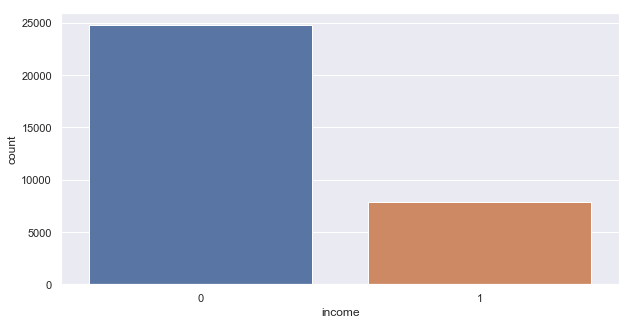

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(data['income'])

As one can see, there is considerable class imbalance in the target variable, i.e. income. This is also intuitively obvious as one expects fewer 'rich' people (earning>50k/annum) than 'not-so-rich' people (earning <50k/annum). Therefore we might need to consider over-sampling techniques in our ML model to improve our accuracy.

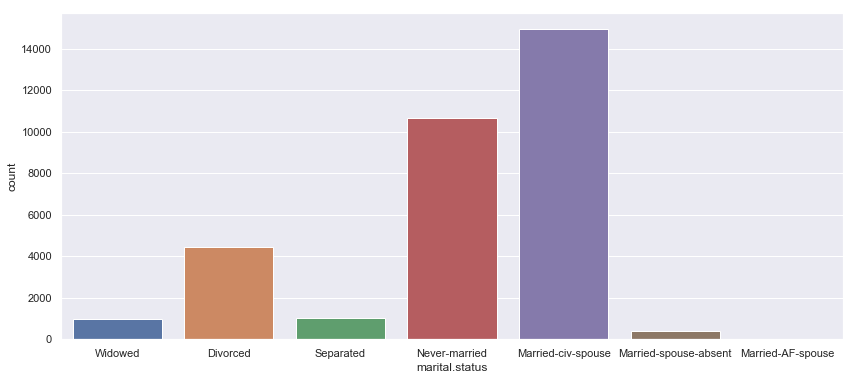

In [13]:
plt.figure(figsize=(14,6))
sns.countplot(data['marital.status'])

Those with `Never-married` and `Married-civ-spouse` labels dominate the dataset.

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

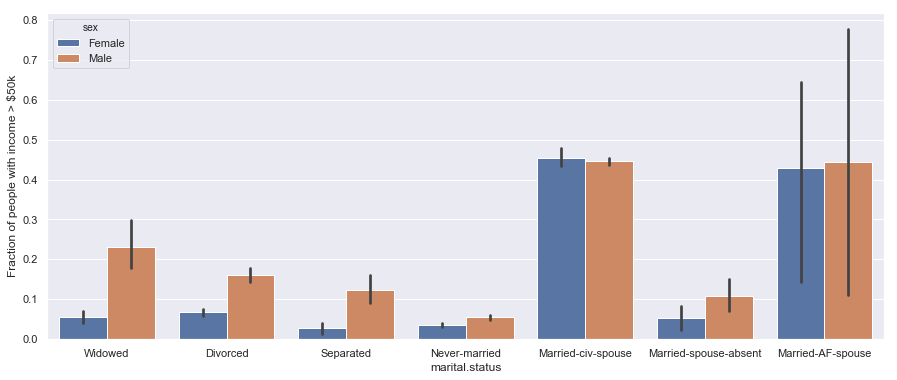

In [15]:
plt.figure(figsize=(15,6))
ax=sns.barplot(x='marital.status',y='income',data=data,hue='sex')
ax.set(ylabel='Fraction of people with income > $50k')
data['marital.status'].value_counts()

The above plot shows the the fraction of people earning more than $50k per annum, grouped by their marital status and gender. The data shows that married people have a higher %age of high-earners, compared to those who either never married or are widowed/divorced/separated. The black lines indicate 2 standard deviations (or 95\% confidence interval) in the data set. The married spouses of armed forces personnel have a much higher variation in their income compared to civil spouses because of low-number statistics.

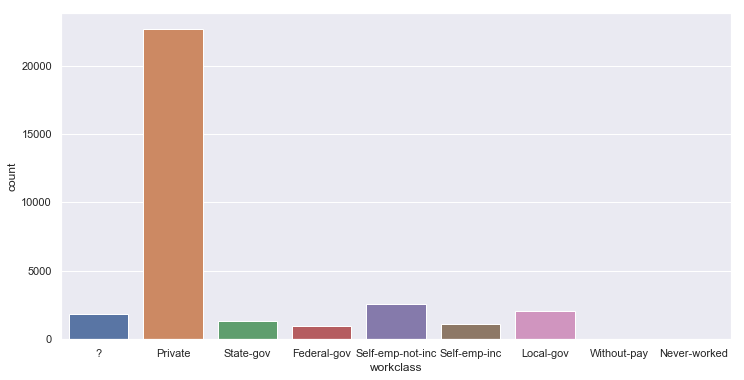

In [16]:
plt.figure(figsize=(12,6))
sns.countplot(data['workclass'])

[Text(0, 0.5, 'Fraction of people with income > $50k')]

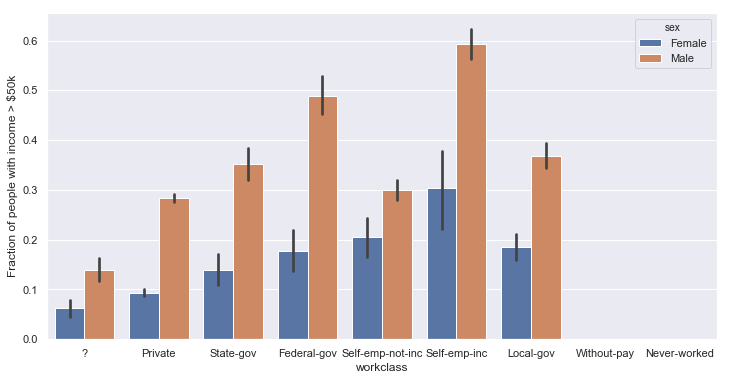

In [17]:
plt.figure(figsize=(12,6))
ax=sns.barplot('workclass', y='income', data=data, hue='sex')
ax.set(ylabel='Fraction of people with income > $50k')

Text(0.5, 1.0, 'Heatmap showing correlations between numerical data')

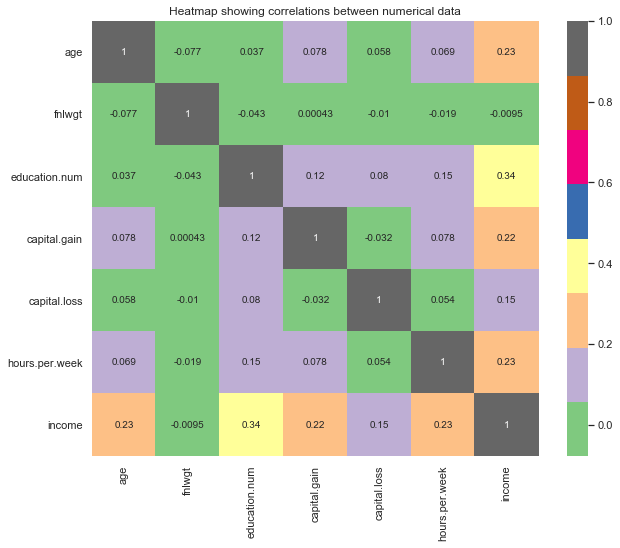

In [20]:
plt.figure(figsize=(10,8))  
sns.heatmap(data.corr(),cmap='Accent',annot=True)
#data.corr()
plt.title('Heatmap showing correlations between numerical data')

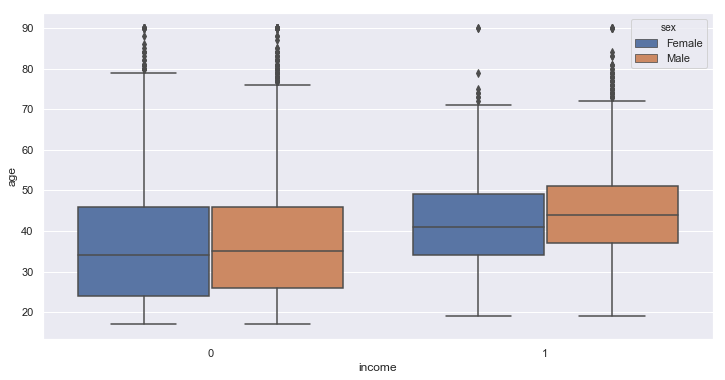

In [21]:
plt.figure(figsize=(12,6))
sns.boxplot(x="income", y="age", data=data, hue='sex')
#data[data['income']==0]['age'].mean()

The mean age of people earning more than 50k per annum is around 44 whereas the mean age of of those earning less than 50k per annum is 36.

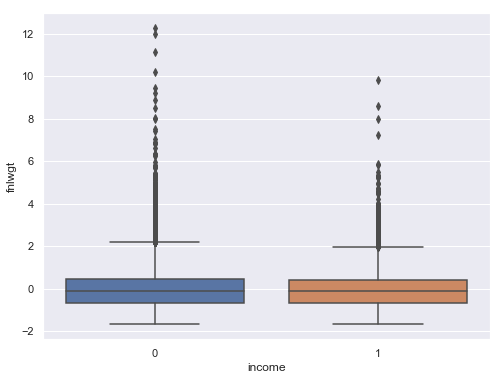

In [27]:
norm_fnl = (data["fnlwgt"] - data['fnlwgt'].mean())/data['fnlwgt'].std()
plt.figure(figsize=(8,6))
sns.boxplot(x="income", y=norm_fnl, data=data)

As evident from the plot above, there are many outliers in the `fnlwgt` column and this feature is uncorrelated with `income`, our target variable. The correlation coefficient (which one can read from the heatmap) is -0.0095. The number of outliers, i.e. the number of records which are more than 2 s.d's away from the mean, is 1249.

In [23]:
data[norm_fnl>2].shape

(1249, 15)

[Text(0, 0.5, 'Fraction of people with income > $50k')]

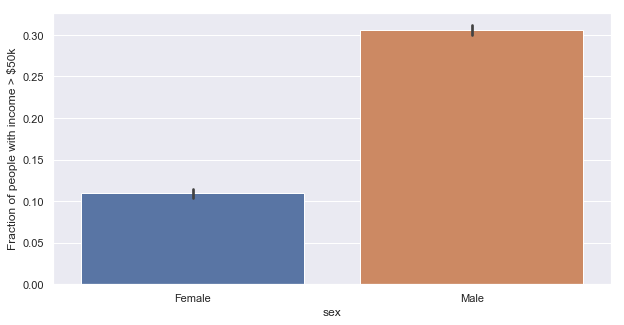

In [39]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='sex',y='income',data=data)
ax.set(ylabel='Fraction of people with income > $50k')

The fraction of rich among men is significantly higher than that among women.

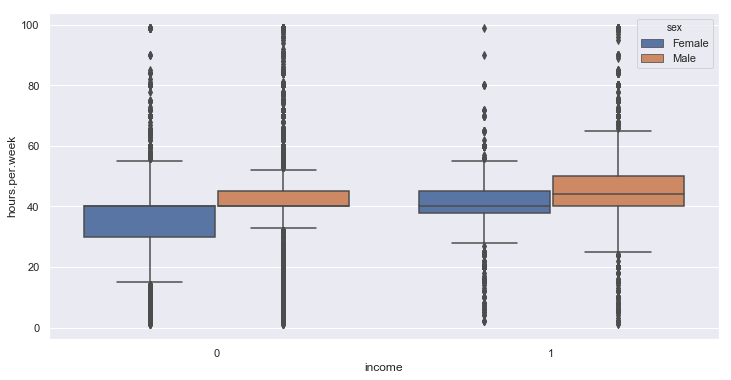

In [28]:
plt.figure(figsize=(12,6))
sns.boxplot(x='income',y ='hours.per.week', hue='sex',data=data)

On the basis of the above plot, we can only conclude that males put in slightly more hours per week than women on an average.

[Text(0, 0.5, 'mean hours per week')]

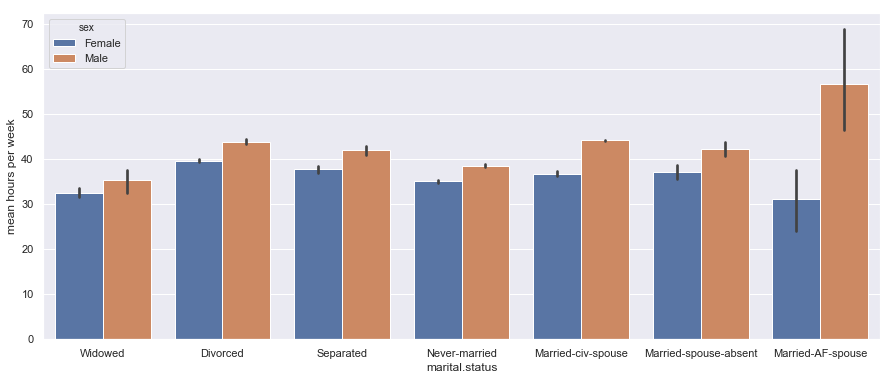

In [29]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='marital.status',y='hours.per.week',data=data,hue='sex')
ax.set(ylabel='mean hours per week')

[Text(0, 0.5, 'Mean education')]

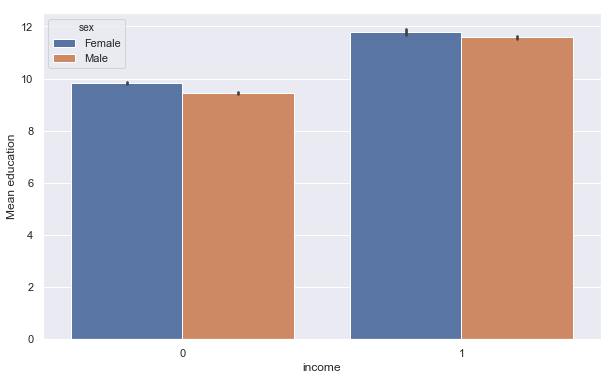

In [30]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='income', y='education.num',hue='sex', data=data)
ax.set(ylabel='Mean education')

The `education.num` is label encoded such that a higher number corresponds to a higher level of education. As on would naïvely expect, people who earn more (>50k per annum) are also highly educated. The mean education level for `income=1` class is between 11 (Assoc-voc) and 12 (Assoc-acdm) whereas that for the `income=0` class is between 9 (HS-grad) and 10 (Some-college).

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


[Text(0, 0.5, 'Fraction of people with income > $50k')]

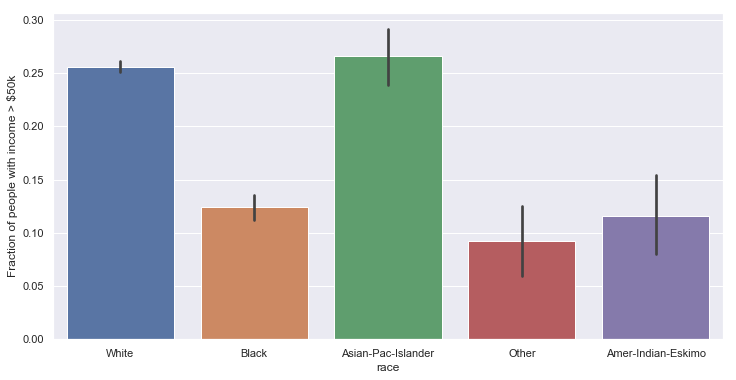

In [31]:
print(data['race'].value_counts())
plt.figure(figsize=(12,6))
ax=sns.barplot(x='race',y='income',data=data)
ax.set(ylabel='Fraction of people with income > $50k')

<Figure size 864x432 with 0 Axes>

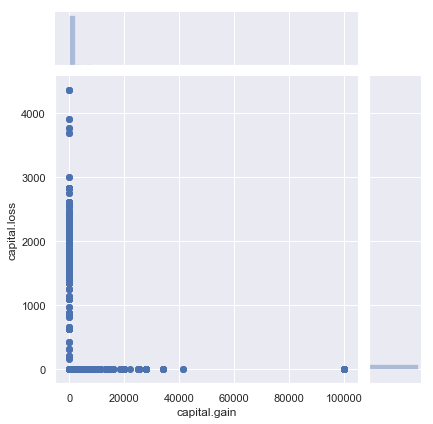

In [32]:
plt.figure(figsize=(12,6))
sns.jointplot(x=data['capital.gain'], y=data['capital.loss'])
#print(data[((data['capital.gain']!=0) & (data['capital.loss']!=0))].shape)

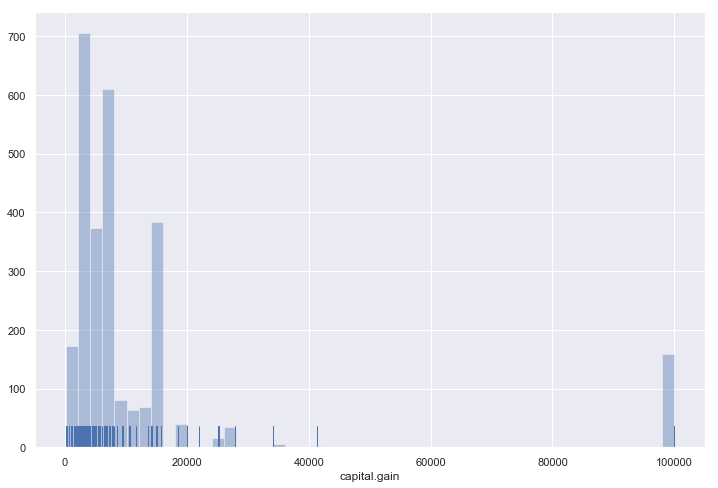

In [33]:
plt.figure(figsize=(12,8))
sns.distplot(data[(data['capital.gain']!=0)]['capital.gain'],kde=False, rug=True)

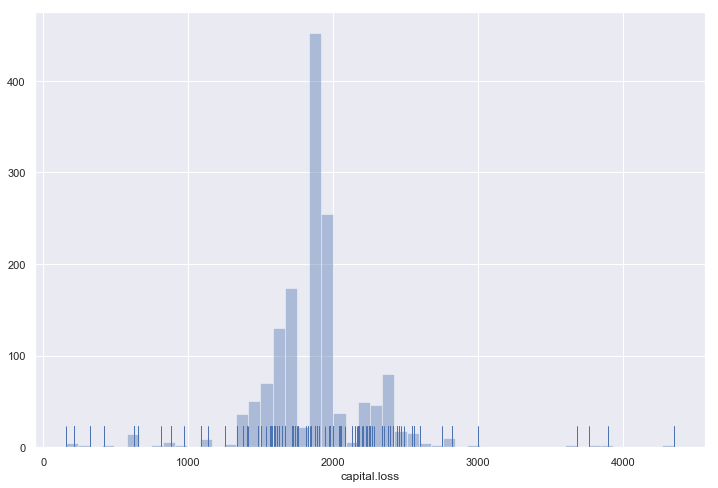

In [34]:
plt.figure(figsize=(12,8))
sns.distplot(data[(data['capital.loss']!=0)]['capital.loss'], kde=False,rug=True)

[Text(0, 0.5, 'Fraction of people with income > $50k')]

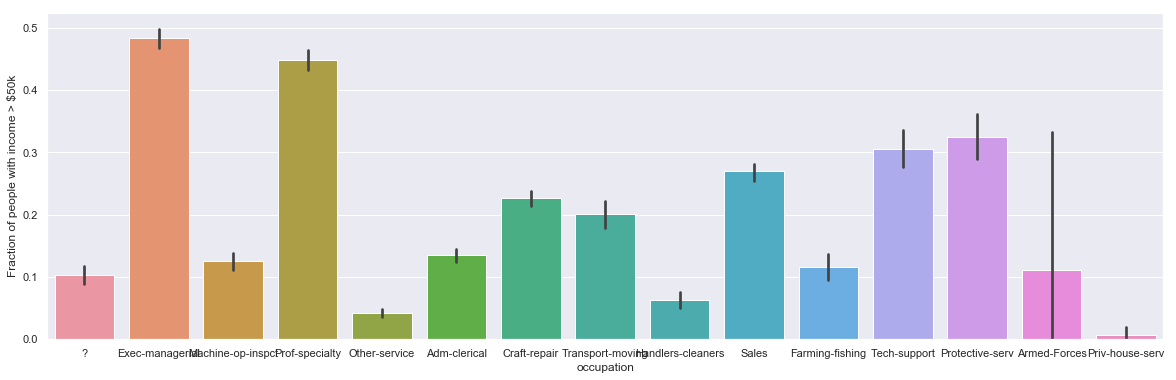

In [35]:
plt.figure(figsize=(20,6))
ax=sns.barplot(x='occupation', y='income', data=data)
ax.set(ylabel='Fraction of people with income > $50k')

In [36]:
print(data['native.country'].value_counts())
not_from_US = np.sum(data['native.country']!='United-States')
print(not_from_US, 'people are not from the United States')

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

#### Convert the `native.country` feature to binary since there is a huge imbalance in this feature

In [37]:
data['native.country'] = (data['native.country']=='United-States')*1
#data['US_or_not']=np.where(data['native.country']=='United-States',1,0)

In [38]:
data.select_dtypes(exclude=[np.number]).head()

,workclass,education,marital.status,occupation,relationship,race,sex
0,?,HS-grad,Widowed,?,Not-in-family,White,Female
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female
2,?,Some-college,Widowed,?,Unmarried,Black,Female
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female


In [40]:
#Replace all '?'s with NaNs.
data = data.applymap(lambda x: np.nan if x=='?' else x)

In [ ]:
data.isnull().sum(axis=0) # How many issing values are there in the dataset?

In [ ]:
data.shape[0] - data.dropna(axis=0).shape[0]   # how many rows will be removed if I remove all the NaN's?

In [ ]:
data = data.dropna(axis=0) ## Drop all the NaNs

In [ ]:
#data.education.value_counts()  # I will label-encode the education column since it is an ordinal categorical variable

In [ ]:
## This computes the fraction of people by country who earn >50k per annum
#mean_income_bycountry_df = data[['native.country','income']].groupby(['native.country']).mean().reset_index()

In [ ]:
#edu_encode_dict = {'Preschool':0,'1st-4th':1, '5th-6th':2, '7th-8th':3, '9th':4, '10th':5,
#                  '11th':6, '12th':7, 'HS-grad':8, 'Some-college':9, 'Bachelors':10, 'Masters':11, 'Assoc-voc':12, 
#                   'Assoc-acdm':13, 'Doctorate':14, 'Prof-school':15}

#data['education'] = data['education'].apply(lambda ed_level: edu_encode_dict[ed_level])

### One-hot encoding of the categorical columns

In [41]:
data = pd.get_dummies(data,columns=['workclass','sex', 'marital.status',
                                    'race','relationship','occupation'],
               prefix=['workclass', 'is', 'is', 'race_is', 'relation', 'is'], drop_first=True)
### native country is ignored because that feature will be dropped later

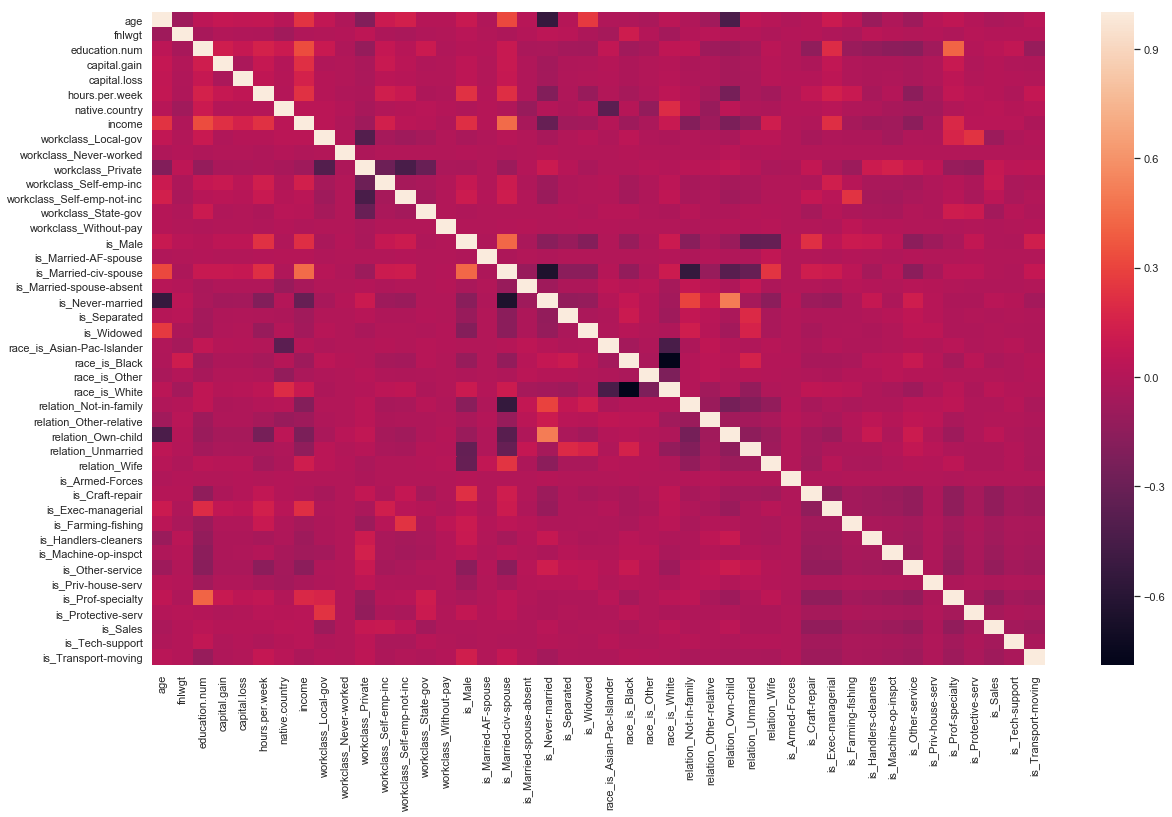

In [42]:
plt.figure(figsize=(20,12))
sns.heatmap(data.corr())

In [43]:
data.select_dtypes(exclude=[np.number]).shape

(32561, 1)

In [44]:
data.groupby('income').mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,native.country,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,is_Farming-fishing,is_Handlers-cleaners,is_Machine-op-inspct,is_Other-service,is_Priv-house-serv,is_Prof-specialty,is_Protective-serv,is_Sales,is_Tech-support,is_Transport-moving
income,,,,,,,,,,,,,,,,,,,,,
0,36.783738,190340.86517,9.595065,148.752468,53.142921,38.840210,0.889927,0.059709,0.000283,0.717354,...,0.035558,0.051942,0.070874,0.127751,0.005987,0.092273,0.017718,0.107888,0.026092,0.051659
1,44.249841,188005.00000,11.611657,4006.142456,195.001530,45.473026,0.914552,0.078689,0.000000,0.632955,...,0.014666,0.010968,0.031884,0.017472,0.000128,0.237087,0.026910,0.125367,0.036092,0.040811


In [45]:
data.shape

(32561, 45)

In [46]:
y = data.income
X = data.drop(['income', 'education', 'native.country', 'fnlwgt'],axis=1)

- `income` is dropped from X because it is the target variable.
- `Education` is dropped because it is already label-encoded in `education.num`. One can notice the high correlation between `education` and `education.num` in the heatmap.
- `native country` is dropped because it showed very little feature importance in random forest classifer.
- `fnlwgt` is dropped because it has no correlation with `income`.

## Modelling
This section explores different classification algorithms to maximise the accuracy for predicting income of a person (> 50k/yr or < 50k/yr).

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier as xgb
from sklearn import metrics

### Baseline model
In the baseline model, we predict the minority class for all our train and test (or validation) examples. The resulting accuracy will serve as a benchmark for the ML models. In other words, the sophisticated ML models should have an accuracy which should at least better the baseline one.

In [50]:
baseline_train = np.zeros(y_train.shape[0])
baseline_test = np.zeros(y_test.shape[0])
print('Accuracy on train data: %f%%' % (metrics.accuracy_score(y_train, baseline_train)))
print('Accuracy on test data: %f%%' %  (metrics.accuracy_score(y_test, baseline_test)))

Accuracy on train data: 0.758643%
Accuracy on test data: 0.760467%


### Random Forest classifier

In [51]:
rfmodel = RandomForestClassifier(n_estimators=300,oob_score=True,min_samples_split=5, max_depth=10,random_state=10)
rfmodel.fit(X_train,y_train)
print(rfmodel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)


In [52]:
def show_classifier_metrics(clf, y_train=y_train,y_test=y_test, print_classification_report=True, print_confusion_matrix=True):
    print(clf)
    if print_confusion_matrix:
        print('confusion matrix of training data')
        print(metrics.confusion_matrix(y_train, clf.predict(X_train)))
        print('confusion matrix of test data')
        print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
    if print_classification_report:
        print('classification report of test data')
        print(metrics.classification_report(y_test, clf.predict(X_test)))
    print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, clf.predict(X_test))*100))
    print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, clf.predict(X_train))*100))
    print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, clf.predict(X_test))))

In [53]:
show_classifier_metrics(rfmodel,y_train)
print('oob score = %f'% rfmodel.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)
confusion matrix of training data
[[16610   681]
 [ 2333  3168]]
confusion matrix of test data
[[7125  304]
 [1072 1268]]
classification report of test data
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7429
           1       0.81      0.54      0.65      2340

    accuracy                           0.86      9769
   macro avg       0.84      0.75      0.78      9769
weighted avg       0.85      0.86      0.85      9769

Accuracy on test data: 85.9146

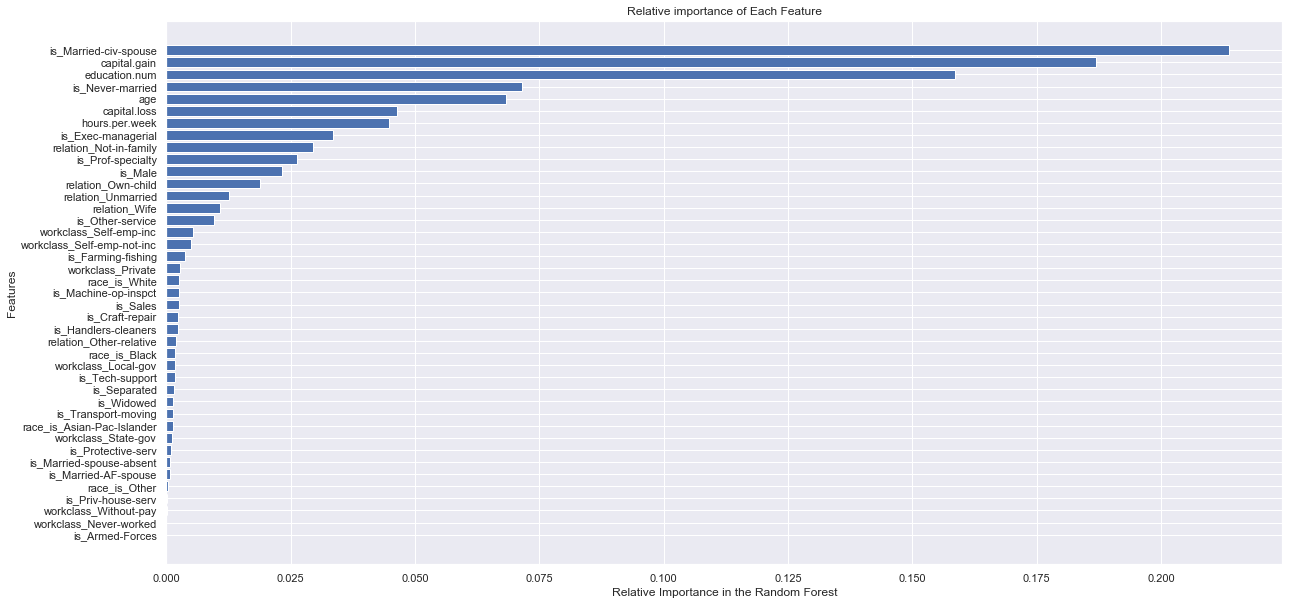

In [54]:
importance_list = rfmodel.feature_importances_
name_list = X_train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20,10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Random forest: Grid Search and cross-validation

In [55]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [56]:
def grid_search(clf, parameters, X, y, n_jobs= -1, n_folds=4, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =2)
    else:
        print('Doing grid search')
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose =2)
    gs.fit(X, y)
    print("mean test score (weighted by split size) of CV rounds: ",gs.cv_results_['mean_test_score'] )
    print ("Best parameter set", gs.best_params_, "Corresponding mean CV score",gs.best_score_)
    best = gs.best_estimator_
    return best

In [57]:
rfmodel2 = RandomForestClassifier(min_samples_split=5,oob_score=True, n_jobs=-1,random_state=10)
parameters = {'n_estimators': [100,200,300], 'max_depth': [10,13,15,20]}
rfmodelCV = grid_search(rfmodel2, parameters,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.1min finished


mean test score (weighted by split size) of CV rounds:  [0.85990698 0.85995086 0.85968761 0.86113549 0.86157424 0.86104774
 0.86161811 0.86205686 0.86267111 0.86038961 0.86188136 0.86166199]
Best parameter set {'max_depth': 15, 'n_estimators': 300} Corresponding mean CV score 0.8626711126711126


In [58]:
rfmodelCV.fit(X_train,y_train)
show_classifier_metrics(rfmodelCV,y_train)
print('oob score = %f'% rfmodelCV.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)
confusion matrix of training data
[[16686   605]
 [ 1995  3506]]
confusion matrix of test data
[[7103  326]
 [1017 1323]]
classification report of test data
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7429
           1       0.80      0.57      0.66      2340

    accuracy                           0.86      9769
   macro avg       0.84      0.76      0.79      9769
weighted avg       0.86      0.86      0.85      9769

Accuracy on test data: 86.252431

## XGBoost 

In [59]:
from xgboost.sklearn import XGBClassifier

In [61]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5
param['n_estimators'] = 400
param['seed']=10
xgb= XGBClassifier(**param)
xgb.fit(X_train, y_train, eval_metric=['error'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.175325	validation_1-error:0.178831
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.144963	validation_1-error:0.145665
[2]	validation_0-error:0.150623	validation_1-error:0.152523
[3]	validation_0-error:0.144568	validation_1-error:0.146074
[4]	validation_0-error:0.143384	validation_1-error:0.143618
[5]	validation_0-error:0.143384	validation_1-error:0.144334
[6]	validation_0-error:0.14334	validation_1-error:0.143822
[7]	validation_0-error:0.143077	validation_1-error:0.144334
[8]	validation_0-error:0.143164	validation_1-error:0.144436
[9]	validation_0-error:0.14334	validation_1-error:0.144641
[10]	validation_0-error:0.143252	validation_1-error:0.144436
[11]	validation_0-error:0.14391	validation_1-error:0.144948
[12]	validation_0-error:0.142857	validation_1-error:0.144232
[13]	validation_0-error:0.142682	validation_1-error:0.14433

[132]	validation_0-error:0.120349	validation_1-error:0.126113
[133]	validation_0-error:0.120305	validation_1-error:0.126011
[134]	validation_0-error:0.120218	validation_1-error:0.126113
[135]	validation_0-error:0.120174	validation_1-error:0.126216
[136]	validation_0-error:0.120042	validation_1-error:0.126523
[137]	validation_0-error:0.119779	validation_1-error:0.12642
[138]	validation_0-error:0.119998	validation_1-error:0.126318
[139]	validation_0-error:0.120086	validation_1-error:0.12642
[140]	validation_0-error:0.119998	validation_1-error:0.126932
[141]	validation_0-error:0.119691	validation_1-error:0.12683
[142]	validation_0-error:0.119867	validation_1-error:0.126523
[143]	validation_0-error:0.119691	validation_1-error:0.126216
[144]	validation_0-error:0.119735	validation_1-error:0.126318
[145]	validation_0-error:0.119472	validation_1-error:0.126318
[146]	validation_0-error:0.119472	validation_1-error:0.126318
[147]	validation_0-error:0.119428	validation_1-error:0.126625
[148]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9, verbosity=1)

In [62]:
show_classifier_metrics(xgb,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9, verbosity=1)
confusion matrix of training data
[[16408   883]
 [ 1889  3612]]
confusion matrix of test data
[[7054  375]
 [ 852 1488]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7429
           1       0.80      0.64      0.71      2340

    accuracy                           0.87      9769
   macro avg       0.85      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769

Accuracy on test data: 87.439861%
Accuracy on training data:

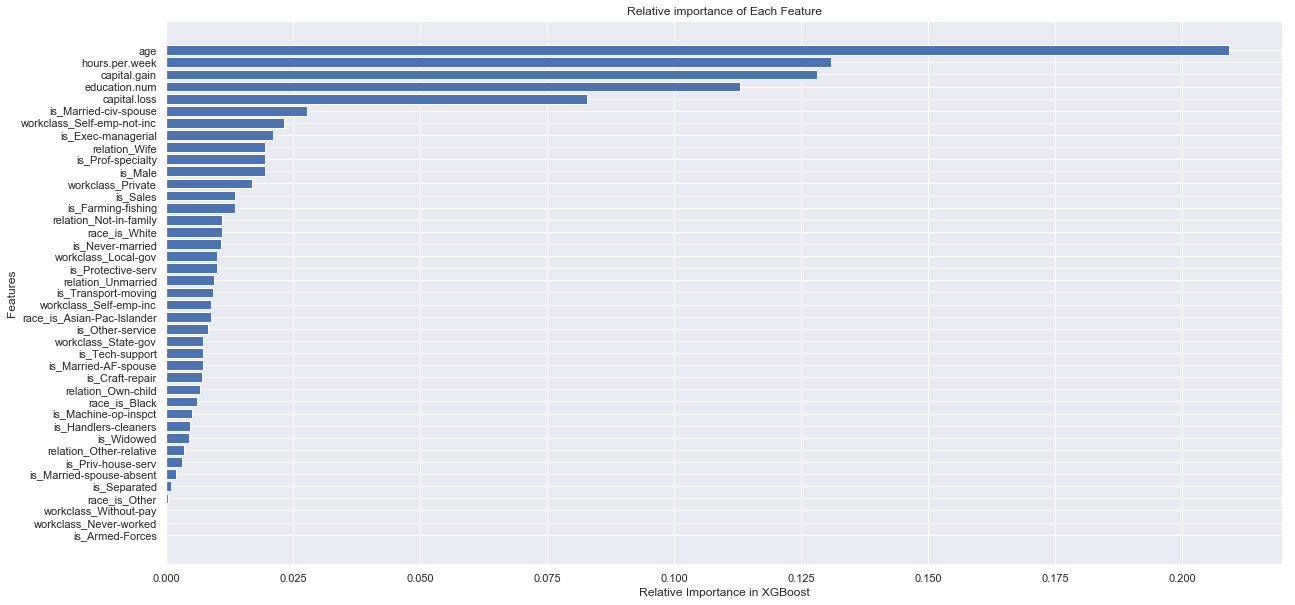

In [63]:
importance_list = xgb.feature_importances_
name_list = X_train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20,10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in XGBoost')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Grid search with cross validation: XGBoost model

In [64]:
xgbmodel2 = XGBClassifier(seed=42)
param = {
'learning_rate': [0.1],#[0.1,0.2],
#'verbosity': [1],
'colsample_bylevel': [0.9],
'colsample_bytree': [0.9],
'subsample' : [0.9],
'n_estimators': [300],
'reg_lambda': [1.5,2,2.5],
'max_depth': [3,5,7],
 'seed': [10]   
}
xgbCV = grid_search(xgbmodel2, param,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.4min finished


mean test score (weighted by split size) of CV rounds:  [0.86982274 0.86938399 0.86876974 0.86938399 0.87017375 0.870788
 0.86565462 0.86587399 0.86565462]
Best parameter set {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_lambda': 2.5, 'seed': 10, 'subsample': 0.9} Corresponding mean CV score 0.8707879957879958


In [65]:
xgbCV.fit(X_train, y_train, eval_metric=['error'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.174316	validation_1-error:0.178831
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.144086	validation_1-error:0.145358
[2]	validation_0-error:0.151501	validation_1-error:0.153854
[3]	validation_0-error:0.14413	validation_1-error:0.145665
[4]	validation_0-error:0.144612	validation_1-error:0.145767
[5]	validation_0-error:0.144437	validation_1-error:0.145255
[6]	validation_0-error:0.143954	validation_1-error:0.144641
[7]	validation_0-error:0.143735	validation_1-error:0.144744
[8]	validation_0-error:0.143559	validation_1-error:0.144744
[9]	validation_0-error:0.14119	validation_1-error:0.143618
[10]	validation_0-error:0.143252	validation_1-error:0.144641
[11]	validation_0-error:0.14255	validation_1-error:0.144129
[12]	validation_0-error:0.142287	validation_1-error:0.143618
[13]	validation_0-error:0.140883	validation_1-error:0.14290

[132]	validation_0-error:0.12092	validation_1-error:0.126113
[133]	validation_0-error:0.120876	validation_1-error:0.126318
[134]	validation_0-error:0.120876	validation_1-error:0.126318
[135]	validation_0-error:0.120876	validation_1-error:0.126318
[136]	validation_0-error:0.120612	validation_1-error:0.126011
[137]	validation_0-error:0.120656	validation_1-error:0.126216
[138]	validation_0-error:0.120788	validation_1-error:0.126011
[139]	validation_0-error:0.120744	validation_1-error:0.12642
[140]	validation_0-error:0.120656	validation_1-error:0.12642
[141]	validation_0-error:0.120744	validation_1-error:0.12642
[142]	validation_0-error:0.120612	validation_1-error:0.126113
[143]	validation_0-error:0.120481	validation_1-error:0.126011
[144]	validation_0-error:0.12013	validation_1-error:0.126011
[145]	validation_0-error:0.119954	validation_1-error:0.125908
[146]	validation_0-error:0.119998	validation_1-error:0.125806
[147]	validation_0-error:0.120086	validation_1-error:0.126216
[148]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=2.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9)

In [66]:
show_classifier_metrics(xgbCV,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=2.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9)
confusion matrix of training data
[[16413   878]
 [ 1857  3644]]
confusion matrix of test data
[[7046  383]
 [ 846 1494]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7429
           1       0.80      0.64      0.71      2340

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769

Accuracy on test data: 87.419388%
Accuracy on training data: 88.000176%
A

In [ ]:
#X_test.iloc[np.where(y_test != xgbCV.predict(X_test))]

## Logistic regression

In [98]:
from sklearn.linear_model import LogisticRegression

In [99]:
param = {
'C': [3,5,10], 
'verbose': [1],
    'max_iter': [100,200,500,700]
}   
logreg = LogisticRegression(random_state=10)
logreg_grid = grid_search(logreg, param, X_train,y_train, n_folds=3)

Doing grid search
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.7s finished
/Users/debashis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]mean test score (weighted by split size) of CV rounds:  [0.8498596 0.8498596 0.8498596 0.8498596 0.8502106 0.8502106 0.8502106
 0.8502106 0.8495086 0.8495086 0.8495086 0.8495086]
Best parameter set {'C': 5, 'max_iter': 100, 'verbose': 1} Corresponding mean CV score 0.8502106002106002


In [100]:
logreg_grid.fit(X_train, y_train)

[LibLinear]

/Users/debashis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=10, solver='warn', tol=0.0001, verbose=1,
                   warm_start=False)

In [101]:
show_classifier_metrics(logreg_grid)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=10, solver='warn', tol=0.0001, verbose=1,
                   warm_start=False)
confusion matrix of training data
[[16110  1181]
 [ 2213  3288]]
confusion matrix of test data
[[6929  500]
 [ 990 1350]]
classification report of test data
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7429
           1       0.73      0.58      0.64      2340

    accuracy                           0.85      9769
   macro avg       0.80      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9769

Accuracy on test data: 84.747671%
Accuracy on training data: 85.108810%
Area under the ROC curve : 0.754810


## Naive Bayes

In [102]:
from sklearn.naive_bayes import GaussianNB

In [103]:
NBmodel = GaussianNB()

In [104]:
NBmodel.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [105]:
NBmodel.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

In [106]:
show_classifier_metrics(NBmodel,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)
confusion matrix of training data
[[14764  2527]
 [ 1443  4058]]
confusion matrix of test data
[[6394 1035]
 [ 640 1700]]
classification report of test data
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      7429
           1       0.62      0.73      0.67      2340

    accuracy                           0.83      9769
   macro avg       0.77      0.79      0.78      9769
weighted avg       0.84      0.83      0.83      9769

Accuracy on test data: 82.853926%
Accuracy on training data: 82.581608%
Area under the ROC curve : 0.793588


### Stacked model

In [111]:
def create_stacked_dataset(clfs,modelnames, X_train=X_train,X_test=X_test):
    X_train_stack, X_test_stack = X_train, X_test
    for clf,modelname in zip(clfs,modelnames):
        temptrain = pd.DataFrame(clf.predict(X_train),index = X_train.index,columns=[modelname+'_prediction'])
        temptest  = pd.DataFrame(clf.predict(X_test),index = X_test.index,columns=[modelname+'_prediction'])
        X_train_stack = pd.concat([X_train_stack, temptrain], axis=1)
        X_test_stack = pd.concat([X_test_stack, temptest], axis=1)
    return (X_train_stack,X_test_stack)

In [113]:
X_train_stack,X_test_stack = create_stacked_dataset([NBmodel,rfmodelCV,logreg_grid,xgb],modelnames=['NBmodel','rfmodelCV','logreg', 'xgb'])

In [114]:
X_train_stack.head(2)

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,is_Priv-house-serv,is_Prof-specialty,is_Protective-serv,is_Sales,is_Tech-support,is_Transport-moving,NBmodel_prediction,rfmodelCV_prediction,logreg_prediction,xgb_prediction
19749,58,9,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1216,62,10,0,1617,33,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [115]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5#10
param['n_estimators'] = 400
param['seed']=10
xgbstack= XGBClassifier(**param)
xgbstack.fit(X_train_stack, y_train, eval_metric=['error'], eval_set=[(X_train_stack, y_train),(X_test_stack, y_test)],early_stopping_rounds=30)


[0]	validation_0-error:0.114075	validation_1-error:0.137476
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.112759	validation_1-error:0.13594
[2]	validation_0-error:0.111794	validation_1-error:0.132665
[3]	validation_0-error:0.111969	validation_1-error:0.132767
[4]	validation_0-error:0.111837	validation_1-error:0.132665
[5]	validation_0-error:0.111881	validation_1-error:0.133176
[6]	validation_0-error:0.112145	validation_1-error:0.133586
[7]	validation_0-error:0.112364	validation_1-error:0.133893
[8]	validation_0-error:0.112188	validation_1-error:0.133688
[9]	validation_0-error:0.112232	validation_1-error:0.133688
[10]	validation_0-error:0.111837	validation_1-error:0.133279
[11]	validation_0-error:0.112013	validation_1-error:0.133483
[12]	validation_0-error:0.112057	validation_1-error:0.133381
[13]	validation_0-error:0.11175	validation_1-error:0.1330

[132]	validation_0-error:0.108942	validation_1-error:0.128161
[133]	validation_0-error:0.108942	validation_1-error:0.128161
[134]	validation_0-error:0.108898	validation_1-error:0.128263
[135]	validation_0-error:0.108898	validation_1-error:0.128263
[136]	validation_0-error:0.108898	validation_1-error:0.128263
[137]	validation_0-error:0.108898	validation_1-error:0.128161
[138]	validation_0-error:0.108898	validation_1-error:0.127956
[139]	validation_0-error:0.108854	validation_1-error:0.127956
[140]	validation_0-error:0.10881	validation_1-error:0.128058
[141]	validation_0-error:0.108854	validation_1-error:0.128058
[142]	validation_0-error:0.108854	validation_1-error:0.128058
[143]	validation_0-error:0.108854	validation_1-error:0.128058
[144]	validation_0-error:0.108766	validation_1-error:0.128161
[145]	validation_0-error:0.108678	validation_1-error:0.128058
[146]	validation_0-error:0.108635	validation_1-error:0.128058
[147]	validation_0-error:0.108635	validation_1-error:0.128263
[148]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9, verbosity=1)

In [116]:
print(metrics.classification_report(y_test, xgbstack.predict(X_test_stack)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgbstack.predict(X_test_stack))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, xgbstack.predict(X_train_stack))*100))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7429
           1       0.81      0.61      0.70      2340

    accuracy                           0.87      9769
   macro avg       0.85      0.78      0.81      9769
weighted avg       0.87      0.87      0.87      9769

Accuracy on test data: 87.204422%
Accuracy on training data: 89.110214%


### Stacked model Grid Search

In [117]:
xgbstackCV = XGBClassifier(seed=10)
param_grid = {}
param_grid['learning_rate'] = [0.1]
param_grid['colsample_bylevel'] = [0.9]
param_grid['colsample_bytree'] = [0.9]
param_grid['subsample'] = [0.9]
param_grid['n_estimators'] = [300]
param_grid['reg_lambda']= [1.5]
param_grid['seed'] =[10]
param_grid['max_depth'] = [3,5,8,10]
xgbstackCV_grid = grid_search(xgbstackCV, param_grid,X_train_stack,y_train)

Doing grid search
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.5min finished


mean test score (weighted by split size) of CV rounds:  [0.88842576 0.88566164 0.87802738 0.87285012]
Best parameter set {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.5, 'seed': 10, 'subsample': 0.9} Corresponding mean CV score 0.8884257634257634


In [118]:
xgbstackCV_grid.fit(X_train_stack, y_train, eval_metric=['error'], eval_set=[(X_train_stack, y_train),(X_test_stack, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.114075	validation_1-error:0.137476
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.114075	validation_1-error:0.137476
[2]	validation_0-error:0.114075	validation_1-error:0.137476
[3]	validation_0-error:0.114075	validation_1-error:0.137476
[4]	validation_0-error:0.114075	validation_1-error:0.137476
[5]	validation_0-error:0.114075	validation_1-error:0.137476
[6]	validation_0-error:0.114075	validation_1-error:0.137476
[7]	validation_0-error:0.114075	validation_1-error:0.137476
[8]	validation_0-error:0.114075	validation_1-error:0.137476
[9]	validation_0-error:0.114075	validation_1-error:0.137476
[10]	validation_0-error:0.114075	validation_1-error:0.137476
[11]	validation_0-error:0.114075	validation_1-error:0.137476
[12]	validation_0-error:0.114075	validation_1-error:0.137476
[13]	validation_0-error:0.114075	validation_1-error:0.13

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9)

In [119]:
print(metrics.classification_report(y_test, xgbstack.predict(X_test_stack)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgbstack.predict(X_test_stack))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, xgbstack.predict(X_train_stack))*100))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7429
           1       0.81      0.61      0.70      2340

    accuracy                           0.87      9769
   macro avg       0.85      0.78      0.81      9769
weighted avg       0.87      0.87      0.87      9769

Accuracy on test data: 87.204422%
Accuracy on training data: 89.110214%


In [120]:
from catboost import CatBoostClassifier

In [121]:
catb = CatBoostClassifier(learning_rate=0.3,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy',rsm=0.9)

In [122]:
catb.fit(X_train,y_train,eval_set=[(X_train,y_train), (X_test,y_test)],early_stopping_rounds=50)

0:	learn: 0.8477536	test: 0.8477536	test1: 0.8453271	best: 0.8453271 (0)	total: 112ms	remaining: 44.8s
1:	learn: 0.8512197	test: 0.8512197	test1: 0.8458389	best: 0.8458389 (1)	total: 162ms	remaining: 32.2s
2:	learn: 0.8495525	test: 0.8495525	test1: 0.8480909	best: 0.8480909 (2)	total: 217ms	remaining: 28.7s
3:	learn: 0.8508687	test: 0.8508687	test1: 0.8507524	best: 0.8507524 (3)	total: 384ms	remaining: 38.1s
4:	learn: 0.8545981	test: 0.8545981	test1: 0.8536186	best: 0.8536186 (4)	total: 488ms	remaining: 38.5s
5:	learn: 0.8566602	test: 0.8566602	test1: 0.8543351	best: 0.8543351 (5)	total: 550ms	remaining: 36.1s
6:	learn: 0.8561776	test: 0.8561776	test1: 0.8539257	best: 0.8543351 (5)	total: 613ms	remaining: 34.4s
7:	learn: 0.8590734	test: 0.8590734	test1: 0.8540280	best: 0.8543351 (5)	total: 687ms	remaining: 33.7s
8:	learn: 0.8589856	test: 0.8589856	test1: 0.8542328	best: 0.8543351 (5)	total: 750ms	remaining: 32.6s
9:	learn: 0.8588540	test: 0.8588540	test1: 0.8539257	best: 0.8543351 (5)	

81:	learn: 0.8777641	test: 0.8777641	test1: 0.8723513	best: 0.8730679 (78)	total: 6.45s	remaining: 25s
82:	learn: 0.8777203	test: 0.8777203	test1: 0.8724537	best: 0.8730679 (78)	total: 6.5s	remaining: 24.8s
83:	learn: 0.8777641	test: 0.8777641	test1: 0.8725560	best: 0.8730679 (78)	total: 6.55s	remaining: 24.6s
84:	learn: 0.8777641	test: 0.8777641	test1: 0.8725560	best: 0.8730679 (78)	total: 6.6s	remaining: 24.4s
85:	learn: 0.8778958	test: 0.8778958	test1: 0.8724537	best: 0.8730679 (78)	total: 6.65s	remaining: 24.3s
86:	learn: 0.8780274	test: 0.8780274	test1: 0.8726584	best: 0.8730679 (78)	total: 6.79s	remaining: 24.4s
87:	learn: 0.8782906	test: 0.8782906	test1: 0.8729655	best: 0.8730679 (78)	total: 6.89s	remaining: 24.4s
88:	learn: 0.8782468	test: 0.8782468	test1: 0.8729655	best: 0.8730679 (78)	total: 7.04s	remaining: 24.6s
89:	learn: 0.8786416	test: 0.8786416	test1: 0.8730679	best: 0.8730679 (78)	total: 7.14s	remaining: 24.6s
90:	learn: 0.8786416	test: 0.8786416	test1: 0.8727608	best:

162:	learn: 0.8815813	test: 0.8815813	test1: 0.8740915	best: 0.8749104 (152)	total: 11.6s	remaining: 16.8s
163:	learn: 0.8813619	test: 0.8813619	test1: 0.8734773	best: 0.8749104 (152)	total: 11.6s	remaining: 16.7s
164:	learn: 0.8814058	test: 0.8814058	test1: 0.8734773	best: 0.8749104 (152)	total: 11.7s	remaining: 16.6s
165:	learn: 0.8817568	test: 0.8817568	test1: 0.8738868	best: 0.8749104 (152)	total: 11.7s	remaining: 16.5s
166:	learn: 0.8816251	test: 0.8816251	test1: 0.8741939	best: 0.8749104 (152)	total: 11.8s	remaining: 16.4s
167:	learn: 0.8815374	test: 0.8815374	test1: 0.8741939	best: 0.8749104 (152)	total: 11.8s	remaining: 16.3s
168:	learn: 0.8814935	test: 0.8814935	test1: 0.8742962	best: 0.8749104 (152)	total: 11.9s	remaining: 16.2s
169:	learn: 0.8814496	test: 0.8814496	test1: 0.8743986	best: 0.8749104 (152)	total: 11.9s	remaining: 16.1s
170:	learn: 0.8814496	test: 0.8814496	test1: 0.8743986	best: 0.8749104 (152)	total: 12s	remaining: 16s
171:	learn: 0.8814058	test: 0.8814058	tes

In [123]:
show_classifier_metrics(catb)

confusion matrix of training data
[[16420   871]
 [ 1842  3659]]
confusion matrix of test data
[[7058  371]
 [ 851 1489]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7429
           1       0.80      0.64      0.71      2340

    accuracy                           0.87      9769
   macro avg       0.85      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769

Accuracy on test data: 87.491043%
Accuracy on training data: 88.096701%
Area under the ROC curve : 0.793193


In [167]:
### Catboost grid search

catbCV = CatBoostClassifier(verbose=1,random_seed=10,eval_metric='Accuracy')
param_grid = {}
param_grid['learning_rate'] = [0.1]#, 0.3]
param_grid['rsm'] = [0.9]
#param_grid['subsample'] = [0.9]
param_grid['iterations'] = [300]
param_grid['reg_lambda']= [2,3]
param_grid['depth'] = [8,10]#5
catbCV_grid = grid_search(catbCV, param_grid,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 11.4min finished


0:	learn: 0.8489382	total: 302ms	remaining: 1m 30s
1:	learn: 0.8508687	total: 555ms	remaining: 1m 22s
2:	learn: 0.8531064	total: 816ms	remaining: 1m 20s
3:	learn: 0.8520534	total: 1.06s	remaining: 1m 18s
4:	learn: 0.8542471	total: 1.31s	remaining: 1m 17s
5:	learn: 0.8554756	total: 1.4s	remaining: 1m 8s
6:	learn: 0.8550369	total: 1.65s	remaining: 1m 8s
7:	learn: 0.8545981	total: 1.74s	remaining: 1m 3s
8:	learn: 0.8567041	total: 1.98s	remaining: 1m 3s
9:	learn: 0.8580204	total: 2.23s	remaining: 1m 4s
10:	learn: 0.8585030	total: 2.48s	remaining: 1m 5s
11:	learn: 0.8596437	total: 2.73s	remaining: 1m 5s
12:	learn: 0.8604335	total: 2.96s	remaining: 1m 5s
13:	learn: 0.8607845	total: 3.2s	remaining: 1m 5s
14:	learn: 0.8604774	total: 3.44s	remaining: 1m 5s
15:	learn: 0.8617497	total: 3.67s	remaining: 1m 5s
16:	learn: 0.8622762	total: 3.77s	remaining: 1m 2s
17:	learn: 0.8623640	total: 4.01s	remaining: 1m 2s
18:	learn: 0.8632415	total: 4.23s	remaining: 1m 2s
19:	learn: 0.8636802	total: 4.46s	rema

161:	learn: 0.8801334	total: 32.7s	remaining: 27.9s
162:	learn: 0.8801334	total: 33s	remaining: 27.7s
163:	learn: 0.8801334	total: 33.2s	remaining: 27.5s
164:	learn: 0.8800456	total: 33.4s	remaining: 27.3s
165:	learn: 0.8801773	total: 33.7s	remaining: 27.2s
166:	learn: 0.8802211	total: 33.9s	remaining: 27s
167:	learn: 0.8800456	total: 34.1s	remaining: 26.8s
168:	learn: 0.8800018	total: 34.4s	remaining: 26.6s
169:	learn: 0.8800018	total: 34.6s	remaining: 26.5s
170:	learn: 0.8803089	total: 34.8s	remaining: 26.3s
171:	learn: 0.8803089	total: 34.9s	remaining: 26s
172:	learn: 0.8803089	total: 35.1s	remaining: 25.8s
173:	learn: 0.8803089	total: 35.2s	remaining: 25.5s
174:	learn: 0.8802650	total: 35.4s	remaining: 25.3s
175:	learn: 0.8803089	total: 35.6s	remaining: 25.1s
176:	learn: 0.8803089	total: 35.9s	remaining: 24.9s
177:	learn: 0.8802211	total: 36.1s	remaining: 24.7s
178:	learn: 0.8801773	total: 36.3s	remaining: 24.6s
179:	learn: 0.8801773	total: 36.4s	remaining: 24.3s
180:	learn: 0.8802

In [168]:
catbCV_grid.fit(X_train,y_train,eval_set=[(X_train,y_train), (X_test,y_test)],early_stopping_rounds=50)

0:	learn: 0.8489382	test: 0.8489382	test1: 0.8447129	best: 0.8447129 (0)	total: 226ms	remaining: 1m 7s
1:	learn: 0.8508687	test: 0.8508687	test1: 0.8468625	best: 0.8468625 (1)	total: 453ms	remaining: 1m 7s
2:	learn: 0.8531064	test: 0.8531064	test1: 0.8488075	best: 0.8488075 (2)	total: 704ms	remaining: 1m 9s
3:	learn: 0.8520534	test: 0.8520534	test1: 0.8472720	best: 0.8488075 (2)	total: 940ms	remaining: 1m 9s
4:	learn: 0.8542471	test: 0.8542471	test1: 0.8503429	best: 0.8503429 (4)	total: 1.16s	remaining: 1m 8s
5:	learn: 0.8554756	test: 0.8554756	test1: 0.8529020	best: 0.8529020 (5)	total: 1.27s	remaining: 1m 2s
6:	learn: 0.8550369	test: 0.8550369	test1: 0.8523902	best: 0.8529020 (5)	total: 1.52s	remaining: 1m 3s
7:	learn: 0.8545981	test: 0.8545981	test1: 0.8523902	best: 0.8529020 (5)	total: 1.61s	remaining: 59s
8:	learn: 0.8567041	test: 0.8567041	test1: 0.8529020	best: 0.8529020 (5)	total: 1.85s	remaining: 59.9s
9:	learn: 0.8580204	test: 0.8580204	test1: 0.8548470	best: 0.8548470 (9)	to

79:	learn: 0.8748684	test: 0.8748684	test1: 0.8679496	best: 0.8683591 (77)	total: 14.8s	remaining: 40.6s
80:	learn: 0.8753071	test: 0.8753071	test1: 0.8685638	best: 0.8685638 (80)	total: 15s	remaining: 40.6s
81:	learn: 0.8753071	test: 0.8753071	test1: 0.8688709	best: 0.8688709 (81)	total: 15.1s	remaining: 40s
82:	learn: 0.8753071	test: 0.8753071	test1: 0.8687686	best: 0.8688709 (81)	total: 15.2s	remaining: 39.8s
83:	learn: 0.8755265	test: 0.8755265	test1: 0.8684615	best: 0.8688709 (81)	total: 15.5s	remaining: 39.8s
84:	learn: 0.8754388	test: 0.8754388	test1: 0.8686662	best: 0.8688709 (81)	total: 15.7s	remaining: 39.7s
85:	learn: 0.8752633	test: 0.8752633	test1: 0.8686662	best: 0.8688709 (81)	total: 15.9s	remaining: 39.6s
86:	learn: 0.8752633	test: 0.8752633	test1: 0.8686662	best: 0.8688709 (81)	total: 16s	remaining: 39.1s
87:	learn: 0.8753510	test: 0.8753510	test1: 0.8685638	best: 0.8688709 (81)	total: 16.2s	remaining: 39s
88:	learn: 0.8753949	test: 0.8753949	test1: 0.8687686	best: 0.8

157:	learn: 0.8799140	test: 0.8799140	test1: 0.8742962	best: 0.8745010 (153)	total: 30.4s	remaining: 27.4s
158:	learn: 0.8799140	test: 0.8799140	test1: 0.8745010	best: 0.8745010 (153)	total: 30.6s	remaining: 27.2s
159:	learn: 0.8799140	test: 0.8799140	test1: 0.8747057	best: 0.8747057 (159)	total: 30.9s	remaining: 27s
160:	learn: 0.8800018	test: 0.8800018	test1: 0.8742962	best: 0.8747057 (159)	total: 31.1s	remaining: 26.8s
161:	learn: 0.8801334	test: 0.8801334	test1: 0.8745010	best: 0.8747057 (159)	total: 31.3s	remaining: 26.6s
162:	learn: 0.8801334	test: 0.8801334	test1: 0.8743986	best: 0.8747057 (159)	total: 31.5s	remaining: 26.5s
163:	learn: 0.8801334	test: 0.8801334	test1: 0.8742962	best: 0.8747057 (159)	total: 31.7s	remaining: 26.3s
164:	learn: 0.8800456	test: 0.8800456	test1: 0.8742962	best: 0.8747057 (159)	total: 31.9s	remaining: 26.1s
165:	learn: 0.8801773	test: 0.8801773	test1: 0.8742962	best: 0.8747057 (159)	total: 32.2s	remaining: 26s
166:	learn: 0.8802211	test: 0.8802211	tes

In [169]:
show_classifier_metrics(catbCV_grid)

confusion matrix of training data
[[16429   862]
 [ 1875  3626]]
confusion matrix of test data
[[7057  372]
 [ 852 1488]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7429
           1       0.80      0.64      0.71      2340

    accuracy                           0.87      9769
   macro avg       0.85      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769

Accuracy on test data: 87.470570%
Accuracy on training data: 87.991400%
Area under the ROC curve : 0.792912


In [124]:
from imblearn.over_sampling import RandomOverSampler

/Users/debashis/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [125]:
np.sum(y_train)/y_train.shape[0]

0.24135661635661634

In [139]:
ros = RandomOverSampler(random_state=1,sampling_strategy=0.8)

In [140]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [150]:
catb_ros = CatBoostClassifier(learning_rate=0.1,iterations=400,reg_lambda=2,verbose=1,random_seed=10,eval_metric='Accuracy')

In [151]:
catb_ros.fit(X_resampled,y_resampled,eval_set=[(X_resampled,y_resampled), (X_test,y_test)],early_stopping_rounds=40)

0:	learn: 0.8032645	test: 0.8032645	test1: 0.7948613	best: 0.7948613 (0)	total: 63.4ms	remaining: 25.3s
1:	learn: 0.8070559	test: 0.8070559	test1: 0.7912785	best: 0.7948613 (0)	total: 127ms	remaining: 25.4s
2:	learn: 0.8115220	test: 0.8115220	test1: 0.7997748	best: 0.7997748 (2)	total: 202ms	remaining: 26.8s
3:	learn: 0.8085018	test: 0.8085018	test1: 0.7948613	best: 0.7997748 (2)	total: 261ms	remaining: 25.9s
4:	learn: 0.8138354	test: 0.8138354	test1: 0.8037670	best: 0.8037670 (4)	total: 341ms	remaining: 26.9s
5:	learn: 0.8156990	test: 0.8156990	test1: 0.8057119	best: 0.8057119 (5)	total: 398ms	remaining: 26.1s
6:	learn: 0.8169200	test: 0.8169200	test1: 0.8088852	best: 0.8088852 (6)	total: 456ms	remaining: 25.6s
7:	learn: 0.8167272	test: 0.8167272	test1: 0.8075545	best: 0.8088852 (6)	total: 514ms	remaining: 25.2s
8:	learn: 0.8186871	test: 0.8186871	test1: 0.8112396	best: 0.8112396 (8)	total: 585ms	remaining: 25.4s
9:	learn: 0.8201009	test: 0.8201009	test1: 0.8128775	best: 0.8128775 (9)

81:	learn: 0.8458375	test: 0.8458375	test1: 0.8435869	best: 0.8440987 (78)	total: 6.73s	remaining: 26.1s
82:	learn: 0.8460945	test: 0.8460945	test1: 0.8444058	best: 0.8444058 (82)	total: 6.78s	remaining: 25.9s
83:	learn: 0.8459017	test: 0.8459017	test1: 0.8445081	best: 0.8445081 (83)	total: 6.84s	remaining: 25.7s
84:	learn: 0.8461588	test: 0.8461588	test1: 0.8454294	best: 0.8454294 (84)	total: 6.89s	remaining: 25.5s
85:	learn: 0.8457732	test: 0.8457732	test1: 0.8456341	best: 0.8456341 (85)	total: 6.96s	remaining: 25.4s
86:	learn: 0.8459981	test: 0.8459981	test1: 0.8456341	best: 0.8456341 (85)	total: 7s	remaining: 25.2s
87:	learn: 0.8462552	test: 0.8462552	test1: 0.8449176	best: 0.8456341 (85)	total: 7.1s	remaining: 25.2s
88:	learn: 0.8465122	test: 0.8465122	test1: 0.8452247	best: 0.8456341 (85)	total: 7.2s	remaining: 25.1s
89:	learn: 0.8464801	test: 0.8464801	test1: 0.8455318	best: 0.8456341 (85)	total: 7.29s	remaining: 25.1s
90:	learn: 0.8464480	test: 0.8464480	test1: 0.8457365	best: 

160:	learn: 0.8545127	test: 0.8545127	test1: 0.8494216	best: 0.8497287 (158)	total: 12.8s	remaining: 19s
161:	learn: 0.8545449	test: 0.8545449	test1: 0.8494216	best: 0.8497287 (158)	total: 12.9s	remaining: 18.9s
162:	learn: 0.8548983	test: 0.8548983	test1: 0.8495240	best: 0.8497287 (158)	total: 13s	remaining: 18.9s
163:	learn: 0.8549304	test: 0.8549304	test1: 0.8497287	best: 0.8497287 (158)	total: 13.1s	remaining: 18.8s
164:	learn: 0.8549947	test: 0.8549947	test1: 0.8495240	best: 0.8497287 (158)	total: 13.2s	remaining: 18.8s
165:	learn: 0.8549947	test: 0.8549947	test1: 0.8495240	best: 0.8497287 (158)	total: 13.2s	remaining: 18.7s
166:	learn: 0.8557658	test: 0.8557658	test1: 0.8494216	best: 0.8497287 (158)	total: 13.3s	remaining: 18.6s
167:	learn: 0.8559265	test: 0.8559265	test1: 0.8498311	best: 0.8498311 (167)	total: 13.4s	remaining: 18.5s
168:	learn: 0.8558944	test: 0.8558944	test1: 0.8498311	best: 0.8498311 (167)	total: 13.4s	remaining: 18.3s
169:	learn: 0.8559265	test: 0.8559265	tes

237:	learn: 0.8617421	test: 0.8617421	test1: 0.8505477	best: 0.8511618 (230)	total: 18.2s	remaining: 12.4s
238:	learn: 0.8619028	test: 0.8619028	test1: 0.8502406	best: 0.8511618 (230)	total: 18.3s	remaining: 12.3s
239:	learn: 0.8615815	test: 0.8615815	test1: 0.8504453	best: 0.8511618 (230)	total: 18.4s	remaining: 12.2s
240:	learn: 0.8614529	test: 0.8614529	test1: 0.8503429	best: 0.8511618 (230)	total: 18.5s	remaining: 12.2s
241:	learn: 0.8614529	test: 0.8614529	test1: 0.8505477	best: 0.8511618 (230)	total: 18.6s	remaining: 12.2s
242:	learn: 0.8614529	test: 0.8614529	test1: 0.8502406	best: 0.8511618 (230)	total: 18.7s	remaining: 12.1s
243:	learn: 0.8616136	test: 0.8616136	test1: 0.8503429	best: 0.8511618 (230)	total: 18.8s	remaining: 12s
244:	learn: 0.8618706	test: 0.8618706	test1: 0.8507524	best: 0.8511618 (230)	total: 18.8s	remaining: 11.9s
245:	learn: 0.8620313	test: 0.8620313	test1: 0.8511618	best: 0.8511618 (230)	total: 18.9s	remaining: 11.8s
246:	learn: 0.8620313	test: 0.8620313	t

314:	learn: 0.8650837	test: 0.8650837	test1: 0.8521855	best: 0.8521855 (298)	total: 25.3s	remaining: 6.84s
315:	learn: 0.8649552	test: 0.8649552	test1: 0.8526973	best: 0.8526973 (315)	total: 25.4s	remaining: 6.75s
316:	learn: 0.8649552	test: 0.8649552	test1: 0.8527997	best: 0.8527997 (316)	total: 25.5s	remaining: 6.67s
317:	learn: 0.8649552	test: 0.8649552	test1: 0.8527997	best: 0.8527997 (316)	total: 25.6s	remaining: 6.59s
318:	learn: 0.8651801	test: 0.8651801	test1: 0.8526973	best: 0.8527997 (316)	total: 25.6s	remaining: 6.51s
319:	learn: 0.8651801	test: 0.8651801	test1: 0.8526973	best: 0.8527997 (316)	total: 25.7s	remaining: 6.43s
320:	learn: 0.8654693	test: 0.8654693	test1: 0.8527997	best: 0.8527997 (316)	total: 25.8s	remaining: 6.34s
321:	learn: 0.8654371	test: 0.8654371	test1: 0.8529020	best: 0.8529020 (321)	total: 25.8s	remaining: 6.26s
322:	learn: 0.8653729	test: 0.8653729	test1: 0.8529020	best: 0.8529020 (321)	total: 25.9s	remaining: 6.17s
323:	learn: 0.8654050	test: 0.8654050

391:	learn: 0.8676541	test: 0.8676541	test1: 0.8532091	best: 0.8536186 (357)	total: 35.1s	remaining: 716ms
392:	learn: 0.8682968	test: 0.8682968	test1: 0.8532091	best: 0.8536186 (357)	total: 35.2s	remaining: 627ms
393:	learn: 0.8683289	test: 0.8683289	test1: 0.8532091	best: 0.8536186 (357)	total: 35.2s	remaining: 537ms
394:	learn: 0.8686823	test: 0.8686823	test1: 0.8533115	best: 0.8536186 (357)	total: 35.3s	remaining: 447ms
395:	learn: 0.8686502	test: 0.8686502	test1: 0.8533115	best: 0.8536186 (357)	total: 35.4s	remaining: 357ms
396:	learn: 0.8685859	test: 0.8685859	test1: 0.8533115	best: 0.8536186 (357)	total: 35.4s	remaining: 268ms
397:	learn: 0.8685538	test: 0.8685538	test1: 0.8533115	best: 0.8536186 (357)	total: 35.5s	remaining: 178ms
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8536185894
bestIteration = 357

Shrink model to first 358 iterations.


In [152]:
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, catb_ros.predict(X_test))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_resampled, catb_ros.predict(X_resampled))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, catb_ros.predict(X_test))))

Accuracy on test data: 85.361859%
Accuracy on training data: 86.591910%
Area under the ROC curve : 0.843451


### SMOTE

In [144]:
from imblearn.over_sampling import SMOTE

In [145]:
smt = SMOTE(random_state=10,sampling_strategy=0.7)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

In [146]:
y_train.value_counts()

0    17291
1     5501
Name: income, dtype: int64

In [147]:
np.bincount(y_train_smt)

array([17291, 12103])

In [153]:
catb_smote = CatBoostClassifier(learning_rate=0.1,iterations=400,reg_lambda=2,verbose=1,random_seed=10,eval_metric='Accuracy')

In [154]:
catb_smote.fit(X_train_smt,y_train_smt,eval_set=[(X_train_smt,y_train_smt), (X_test,y_test)],early_stopping_rounds=40)

0:	learn: 0.7904334	test: 0.7904334	test1: 0.8200430	best: 0.8200430 (0)	total: 88.1ms	remaining: 35.2s
1:	learn: 0.7959788	test: 0.7959788	test1: 0.8298700	best: 0.8298700 (1)	total: 155ms	remaining: 30.8s
2:	learn: 0.8081921	test: 0.8081921	test1: 0.8108302	best: 0.8298700 (1)	total: 215ms	remaining: 28.5s
3:	learn: 0.8081581	test: 0.8081581	test1: 0.8088852	best: 0.8298700 (1)	total: 281ms	remaining: 27.8s
4:	learn: 0.8137715	test: 0.8137715	test1: 0.8182004	best: 0.8298700 (1)	total: 378ms	remaining: 29.9s
5:	learn: 0.8138055	test: 0.8138055	test1: 0.8178933	best: 0.8298700 (1)	total: 439ms	remaining: 28.8s
6:	learn: 0.8161189	test: 0.8161189	test1: 0.8207595	best: 0.8298700 (1)	total: 497ms	remaining: 27.9s
7:	learn: 0.8181942	test: 0.8181942	test1: 0.8215785	best: 0.8298700 (1)	total: 557ms	remaining: 27.3s
8:	learn: 0.8228550	test: 0.8228550	test1: 0.8218856	best: 0.8298700 (1)	total: 638ms	remaining: 27.7s
9:	learn: 0.8243179	test: 0.8243179	test1: 0.8227045	best: 0.8298700 (1)

81:	learn: 0.8646322	test: 0.8646322	test1: 0.8500358	best: 0.8500358 (81)	total: 7.83s	remaining: 30.4s
82:	learn: 0.8646322	test: 0.8646322	test1: 0.8500358	best: 0.8500358 (81)	total: 7.92s	remaining: 30.2s
83:	learn: 0.8651085	test: 0.8651085	test1: 0.8499335	best: 0.8500358 (81)	total: 8.01s	remaining: 30.1s
84:	learn: 0.8649044	test: 0.8649044	test1: 0.8496264	best: 0.8500358 (81)	total: 8.11s	remaining: 30.1s
85:	learn: 0.8658230	test: 0.8658230	test1: 0.8495240	best: 0.8500358 (81)	total: 8.18s	remaining: 29.9s
86:	learn: 0.8662652	test: 0.8662652	test1: 0.8494216	best: 0.8500358 (81)	total: 8.29s	remaining: 29.8s
87:	learn: 0.8661972	test: 0.8661972	test1: 0.8494216	best: 0.8500358 (81)	total: 8.43s	remaining: 29.9s
88:	learn: 0.8663673	test: 0.8663673	test1: 0.8494216	best: 0.8500358 (81)	total: 8.52s	remaining: 29.8s
89:	learn: 0.8660951	test: 0.8660951	test1: 0.8492169	best: 0.8500358 (81)	total: 8.61s	remaining: 29.7s
90:	learn: 0.8665374	test: 0.8665374	test1: 0.8493193	b

162:	learn: 0.8773219	test: 0.8773219	test1: 0.8536186	best: 0.8541304 (141)	total: 14.4s	remaining: 21s
163:	learn: 0.8773559	test: 0.8773559	test1: 0.8538233	best: 0.8541304 (141)	total: 14.5s	remaining: 20.8s
164:	learn: 0.8775941	test: 0.8775941	test1: 0.8542328	best: 0.8542328 (164)	total: 14.5s	remaining: 20.7s
165:	learn: 0.8779003	test: 0.8779003	test1: 0.8541304	best: 0.8542328 (164)	total: 14.6s	remaining: 20.6s
166:	learn: 0.8780363	test: 0.8780363	test1: 0.8543351	best: 0.8543351 (166)	total: 14.8s	remaining: 20.7s
167:	learn: 0.8782405	test: 0.8782405	test1: 0.8543351	best: 0.8543351 (166)	total: 14.9s	remaining: 20.6s
168:	learn: 0.8780704	test: 0.8780704	test1: 0.8539257	best: 0.8543351 (166)	total: 15s	remaining: 20.5s
169:	learn: 0.8782064	test: 0.8782064	test1: 0.8539257	best: 0.8543351 (166)	total: 15.1s	remaining: 20.4s
170:	learn: 0.8782745	test: 0.8782745	test1: 0.8543351	best: 0.8543351 (166)	total: 15.1s	remaining: 20.2s
171:	learn: 0.8783425	test: 0.8783425	tes

241:	learn: 0.8830374	test: 0.8830374	test1: 0.8574061	best: 0.8574061 (237)	total: 19.6s	remaining: 12.8s
242:	learn: 0.8830033	test: 0.8830033	test1: 0.8572014	best: 0.8574061 (237)	total: 19.7s	remaining: 12.7s
243:	learn: 0.8830374	test: 0.8830374	test1: 0.8577132	best: 0.8577132 (243)	total: 19.7s	remaining: 12.6s
244:	learn: 0.8829013	test: 0.8829013	test1: 0.8577132	best: 0.8577132 (243)	total: 19.8s	remaining: 12.5s
245:	learn: 0.8830033	test: 0.8830033	test1: 0.8577132	best: 0.8577132 (243)	total: 19.8s	remaining: 12.4s
246:	learn: 0.8832755	test: 0.8832755	test1: 0.8574061	best: 0.8577132 (243)	total: 19.9s	remaining: 12.3s
247:	learn: 0.8831054	test: 0.8831054	test1: 0.8573037	best: 0.8577132 (243)	total: 20s	remaining: 12.2s
248:	learn: 0.8830714	test: 0.8830714	test1: 0.8574061	best: 0.8577132 (243)	total: 20s	remaining: 12.1s
249:	learn: 0.8832755	test: 0.8832755	test1: 0.8574061	best: 0.8577132 (243)	total: 20.1s	remaining: 12.1s
250:	learn: 0.8832755	test: 0.8832755	tes

321:	learn: 0.8853508	test: 0.8853508	test1: 0.8574061	best: 0.8584297 (287)	total: 24.5s	remaining: 5.92s
322:	learn: 0.8852147	test: 0.8852147	test1: 0.8575084	best: 0.8584297 (287)	total: 24.5s	remaining: 5.84s
323:	learn: 0.8851466	test: 0.8851466	test1: 0.8573037	best: 0.8584297 (287)	total: 24.6s	remaining: 5.76s
324:	learn: 0.8851126	test: 0.8851126	test1: 0.8573037	best: 0.8584297 (287)	total: 24.6s	remaining: 5.68s
325:	learn: 0.8853848	test: 0.8853848	test1: 0.8578155	best: 0.8584297 (287)	total: 24.7s	remaining: 5.61s
326:	learn: 0.8853167	test: 0.8853167	test1: 0.8578155	best: 0.8584297 (287)	total: 24.7s	remaining: 5.52s
327:	learn: 0.8853167	test: 0.8853167	test1: 0.8580203	best: 0.8584297 (287)	total: 24.8s	remaining: 5.44s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8584297267
bestIteration = 287

Shrink model to first 288 iterations.


In [155]:
print(metrics.classification_report(y_test, catb_smote.predict(X_test)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, catb_smote.predict(X_test))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train_smt, catb_smote.predict(X_train_smt))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, catb_ros.predict(X_test))))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7429
           1       0.69      0.74      0.71      2340

    accuracy                           0.86      9769
   macro avg       0.80      0.82      0.81      9769
weighted avg       0.86      0.86      0.86      9769

Accuracy on test data: 85.842973%
Accuracy on training data: 88.460230%
Area under the ROC curve : 0.843451


#### SMOTE with XGBoost

In [159]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5
param['n_estimators'] = 400
param['seed']=10
xgb_smote= XGBClassifier(**param)
xgb_smote.fit(X_train_smt, y_train_smt, eval_metric=['error'], eval_set=[(X_train_smt, y_train_smt),(X_test.values, y_test.values)],early_stopping_rounds=30)

[0]	validation_0-error:0.190787	validation_1-error:0.199406
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.191468	validation_1-error:0.19828
[2]	validation_0-error:0.190447	validation_1-error:0.197666
[3]	validation_0-error:0.189392	validation_1-error:0.198076
[4]	validation_0-error:0.188542	validation_1-error:0.197052
[5]	validation_0-error:0.187113	validation_1-error:0.197359
[6]	validation_0-error:0.176771	validation_1-error:0.183437
[7]	validation_0-error:0.176124	validation_1-error:0.178831
[8]	validation_0-error:0.174117	validation_1-error:0.184052
[9]	validation_0-error:0.169082	validation_1-error:0.176784
[10]	validation_0-error:0.16847	validation_1-error:0.176579
[11]	validation_0-error:0.168232	validation_1-error:0.176477
[12]	validation_0-error:0.169184	validation_1-error:0.176886
[13]	validation_0-error:0.168096	validation_1-error:0.1763

[132]	validation_0-error:0.116146	validation_1-error:0.141058
[133]	validation_0-error:0.115738	validation_1-error:0.141058
[134]	validation_0-error:0.115568	validation_1-error:0.140751
[135]	validation_0-error:0.115806	validation_1-error:0.141468
[136]	validation_0-error:0.11567	validation_1-error:0.141263
[137]	validation_0-error:0.1155	validation_1-error:0.141366
[138]	validation_0-error:0.115296	validation_1-error:0.141366
[139]	validation_0-error:0.115126	validation_1-error:0.141366
[140]	validation_0-error:0.114989	validation_1-error:0.141263
[141]	validation_0-error:0.115126	validation_1-error:0.141161
[142]	validation_0-error:0.114887	validation_1-error:0.140751
[143]	validation_0-error:0.114683	validation_1-error:0.140751
[144]	validation_0-error:0.114649	validation_1-error:0.140547
[145]	validation_0-error:0.114377	validation_1-error:0.140751
[146]	validation_0-error:0.114547	validation_1-error:0.140547
[147]	validation_0-error:0.114275	validation_1-error:0.141058
[148]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9, verbosity=1)

In [166]:
print(metrics.classification_report(y_test, xgb_smote.predict(X_test.values)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgb_smote.predict(X_test.values))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train_smt, xgb_smote.predict(X_train_smt))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, xgb_smote.predict(X_test.values))))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      7429
           1       0.69      0.76      0.72      2340

    accuracy                           0.86      9769
   macro avg       0.80      0.83      0.81      9769
weighted avg       0.87      0.86      0.86      9769

Accuracy on test data: 85.965810%
Accuracy on training data: 88.599714%
Area under the ROC curve : 0.826490
